In [1]:
import matplotlib.pyplot as plt
import numpy
import os
import random
import seaborn
import torch

from data_utils import load_dataset
from eval_utils import get_performance_metrics
from models.houghnet import HoughNet
from models.cash import CASH
from models.ssc import SSC

In [2]:
def plot_data(x, y):
    n_colors = numpy.unique(y).size
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    seaborn.scatterplot(x=x[:, 0], 
                        y=x[:, 1], 
                        hue=y,
                        palette=seaborn.color_palette('pastel', n_colors=n_colors),
                        size=0.5,
                        legend=False,
                        ax=ax,
                       )
    
    return ax

def plot_hyperplanes(model, ax):
    weight = model.weight.detach().cpu().numpy()
    weight /= numpy.linalg.norm(weight, axis=0, keepdims=True) 
    
    bias = model.bias.detach().cpu().numpy()

    for i in range(weight.shape[1]):
        w = weight[:, i]
        b = bias[0, i]
        
        ax.arrow(0, 0, w[0] * b, w[1] * b, head_width=.03, length_includes_head=True)
        
        v0 = -w[1] / (w[0] - w[1])
        v1 = 1. - v0
        v = numpy.array([v0, v1])
        v /= numpy.linalg.norm(v)
        v /= v.max()
  
        ax.arrow(w[0] * b - v[0], w[1] * b - v[1], 2 * v[0], 2 * v[1], head_width=0.)

# Load dataset

In [3]:
data_root = '../data'
dataset_name = '3lines_0.01_0.30'

x, y = load_dataset(data_root=data_root,
                    dataset_name=dataset_name,
                   )
x_path = os.path.join(data_root, f'{dataset_name}.csv')

num_dims = x.shape[1]
num_clusters = numpy.unique(y[y != -1]).size

x_mean = x.mean(axis=0)

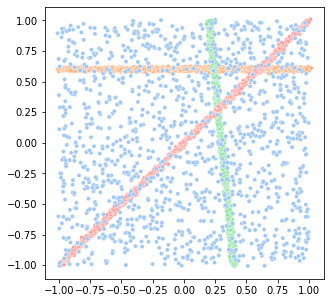

In [4]:
_ = plot_data(x, y)

# Train and evaluate HougNet model

In [5]:
seed = 0

random.seed(seed)
numpy.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
lambda_activation = 0.3

model = HoughNet(num_dims=num_dims,
                 num_clusters=num_clusters,
                 lambda_activation=lambda_activation,
                 initial_data_mean=x_mean,
                )

In [7]:
device = 0
model = model.to(device)

In [8]:
batch_size = 100
learning_rate = 0.1
num_epochs = 10

y_pred = model.fit_predict(x=x,
                           batch_size=batch_size,
                           learning_rate=learning_rate,
                           num_epochs=num_epochs,
                          )

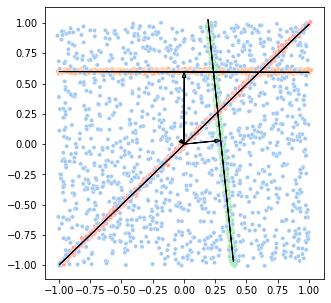

In [9]:
ax = plot_data(x, y)
plot_hyperplanes(model, ax)

In [10]:
acc, ari, nmi = get_performance_metrics(y_true=y, 
                                        y_pred=y_pred,
                                       )

print('--- HoughNet Performance ---')
print(f'ACC = {acc * 100.:.2f}')
print(f'ARI = {ari * 100.:.2f}')
print(f'NMI = {nmi * 100.:.2f}')

--- HoughNet Performance ---
ACC = 98.23
ARI = 94.77
NMI = 90.83


# Evaluate other methods

In [11]:
minPts = 500
maxLevel = 50
jitter = 0.05
minDim = 1
adjust = True

model = CASH(minPts=minPts,
             maxLevel=maxLevel,
             jitter=jitter,
             minDim=minDim,
             adjust=adjust,
            )

y_pred = model.fit_predict(x=x_path)

acc, ari, nmi = get_performance_metrics(y_true=y, 
                                        y_pred=y_pred,
                                       )

print('--- CASH Performance ---')
print(f'ACC = {acc * 100.:.2f}')
print(f'ARI = {ari * 100.:.2f}')
print(f'NMI = {nmi * 100.:.2f}')

--- CASH Performance ---
ACC = 93.73
ARI = 85.82
NMI = 79.46


In [12]:
lambda_regularization = 0.0001

model = SSC(num_dims=num_dims,
            num_clusters=num_clusters,
            lambda_regularization=lambda_regularization
           )

y_pred = model.fit_predict(x=x)

acc, ari, nmi = get_performance_metrics(y_true=y, 
                                        y_pred=y_pred,
                                       )

print('--- SSC Performance ---')
print(f'ACC = {acc * 100.:.2f}')
print(f'ARI = {ari * 100.:.2f}')
print(f'NMI = {nmi * 100.:.2f}')

--- SSC Performance ---
ACC = 62.50
ARI = 19.93
NMI = 30.16
